In [1]:
import numpyro
import numpyro.distributions as dist
import jax.numpy as jnp
from numpyro.infer import MCMC, NUTS

def complex_mvn_logpdf(z, Gamma):
    """Compute logpdf for z ~ CN(0, Gamma), z: (L, K), Gamma: (K, K) Hermitian"""
    L, K = z.shape
    Gamma_inv = jnp.linalg.inv(Gamma)
    logdet = jnp.linalg.slogdet(Gamma)[1]
    quad = jnp.real(jnp.einsum("lk,kl,lp->l", jnp.conj(z), Gamma_inv, z))
    return -K * jnp.log(jnp.pi) - logdet - quad

# def model(z_obs):
#     L, K = z_obs.shape

#     # --- Real part A: symmetric ---
#     A = numpyro.sample("A", dist.Normal(0, 1).expand([K, K]))
#     A = (A + A.T) / 2

#     # --- Imag part B: skew-symmetric ---
#     B_raw = numpyro.sample("B", dist.Normal(0, 1).expand([K, K]))
#     B = (B_raw - B_raw.T) / 2

#     # --- Hermitian complex covariance ---
#     Gamma = A + 1j * B

#     # --- Likelihood: custom complex MVN ---
#     logp = complex_mvn_logpdf(z_obs, Gamma)
#     numpyro.factor("likelihood", jnp.sum(logp))

In [2]:
import numpy as np
def simulate_cscn_data(K=3, n_samples=500, seed=0):
    rng = np.random.default_rng(seed)

    # Random low-rank complex A
    r = K
    A = rng.normal(0, 1, size=(K, r)) + 1j * rng.normal(0, 1, size=(K, r))

    # Hermitian PSD
    Gamma = A @ A.conj().T + 0.5 * np.eye(K)

    from scipy.linalg import cholesky
    L = cholesky(Gamma, lower=True)

    # Standard complex normals
    z_std_normal = rng.normal(size=(n_samples, K)) + 1j * rng.normal(size=(n_samples, K))

    # Correct sampling
    z_samples = (L @ z_std_normal.T) / np.sqrt(2)  # shape (K, n_samples)
    z_samples = z_samples.T  # shape (n_samples, K)

    return z_samples, Gamma

# def simulate_cscn_data(K=3, n_samples=500, seed=0):
#     rng = np.random.default_rng(seed)

#     # Random low-rank complex A
#     r = K
#     A = rng.normal(0, 1, size=(K, r)) + 1j * rng.normal(0, 1, size=(K, r))

#     # Build Hermitian PSD matrix
#     Gamma = A @ A.conj().T + 0.5 * np.eye(K)

#     # Cholesky
#     from scipy.linalg import cholesky
#     L = cholesky(Gamma, lower=True)

#     # Sample from CN(0, Gamma)
#     z_std_normal = rng.normal(size=(n_samples, K)) + 1j * rng.normal(size=(n_samples, K))  # (n_samples, K)
#     z_samples = (z_std_normal @ L.T.conj()) / np.sqrt(2)  # (n_samples, K)

#     return z_samples, Gamma


z_obs, Gamma_true = simulate_cscn_data(K=3, n_samples=500)


In [3]:
print(Gamma_true)

[[2.93487135+0.j         3.34254994+1.27740223j 0.84092837-2.04674892j]
 [3.34254994-1.27740223j 7.93462868+0.j         1.5907056 -2.46261759j]
 [0.84092837+2.04674892j 1.5907056 +2.46261759j 4.52510086+0.j        ]]


In [4]:
z_obs.shape
empirical = np.einsum('lk,lj->lkj', z_obs, z_obs.conj()).mean(0)
print(empirical)

[[2.89453955+0.j         3.24655624+1.2487364j  0.80444256-2.09415931j]
 [3.24655624-1.2487364j  7.51128072+0.j         1.37545699-2.5961539j ]
 [0.80444256+2.09415931j 1.37545699+2.5961539j  4.61091329+0.j        ]]


In [5]:
import numpyro
import numpyro.distributions as dist
import jax.numpy as jnp

def complex_mvn_logpdf(z, Gamma):
    """Log-pdf for z ~ CN(0, Gamma), z: (L, K), Gamma: (K, K) Hermitian"""
    L, K = z.shape
    Gamma_inv = jnp.linalg.inv(Gamma)
    sign, logdet = jnp.linalg.slogdet(Gamma)

    # z: (L, K), Gamma_inv: (K, K)
    # Compute quadratic form for each row: zᵢᴴ Γ⁻¹ zᵢ
    quad = jnp.real(jnp.einsum("bi,ij,bj->b", jnp.conj(z), Gamma_inv, z))  # shape (L,)

    return -K * jnp.log(jnp.pi) - logdet - quad


def model(z_obs):
    L, K = z_obs.shape

    # Real part A (symmetric)
    A_raw = numpyro.sample("A_raw", dist.Normal(0, 1).expand([K, K]))
    A = (A_raw + A_raw.T) / 2

    # Imaginary part B (skew-symmetric)
    B_raw = numpyro.sample("B_raw", dist.Normal(0, 1).expand([K, K]))
    B = (B_raw - B_raw.T) / 2

    # Hermitian covariance matrix
    Gamma = A + 1j * B

    # Likelihood
    logp = complex_mvn_logpdf(z_obs, Gamma)
    numpyro.factor("likelihood", jnp.sum(logp))

In [6]:
print(Gamma_true)

[[2.93487135+0.j         3.34254994+1.27740223j 0.84092837-2.04674892j]
 [3.34254994-1.27740223j 7.93462868+0.j         1.5907056 -2.46261759j]
 [0.84092837+2.04674892j 1.5907056 +2.46261759j 4.52510086+0.j        ]]


In [7]:
np.linalg.eigvalsh(Gamma_true)

array([ 0.62071267,  3.19646054, 11.57742767])

In [8]:
import jax.numpy as jnp
z_obs_jax = jnp.array(z_obs)


In [9]:
z_obs_jax.shape

(500, 3)

In [10]:
from jax.random import PRNGKey
from numpyro.infer import MCMC, NUTS

nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=1000, num_chains=1)
mcmc.run(PRNGKey(0), z_obs=z_obs_jax)

posterior = mcmc.get_samples()

A_samples = 0.5 * (posterior["A_raw"] + jnp.transpose(posterior["A_raw"], (0, 2, 1)))
B_samples = 0.5 * (posterior["B_raw"] - jnp.transpose(posterior["B_raw"], (0, 2, 1)))
Gamma_samples = A_samples + 1j * B_samples  # shape: (num_samples, K, K)

sample: 100%|██████████| 1500/1500 [00:02<00:00, 697.53it/s, 3 steps of size 8.77e-05. acc. prob=0.20]  


In [11]:
Gamma_posterior_mean = Gamma_samples.mean(0)

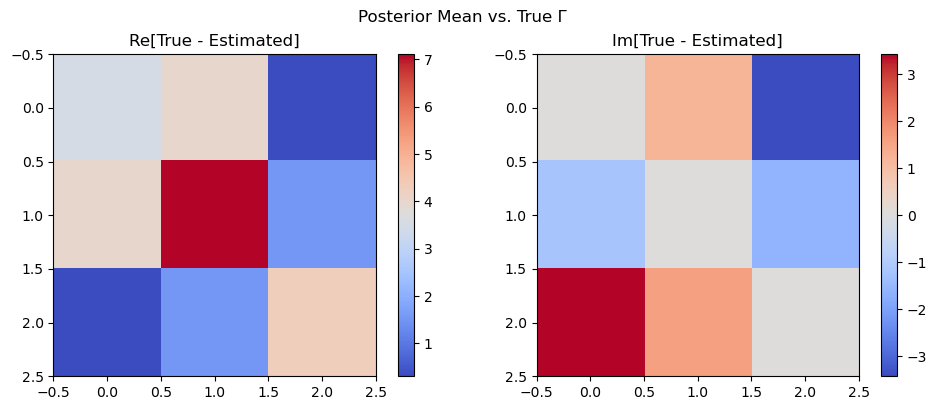

In [12]:
import matplotlib.pyplot as plt

def plot_complex_matrix_diff(true, estimated, title):
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    im0 = axs[0].imshow(np.real(true - estimated), cmap="coolwarm")
    axs[0].set_title("Re[True - Estimated]")
    plt.colorbar(im0, ax=axs[0])

    im1 = axs[1].imshow(np.imag(true - estimated), cmap="coolwarm")
    axs[1].set_title("Im[True - Estimated]")
    plt.colorbar(im1, ax=axs[1])

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

plot_complex_matrix_diff(Gamma_true, Gamma_posterior_mean, "Posterior Mean vs. True Γ")

In [13]:
def model(z_obs):
    L, K = z_obs.shape
    r = K  # rank of factor — can set r < K for low-rank models

    # --- Real and Imag parts of L ---
    L_real = numpyro.sample("L_real", dist.Normal(0, 1).expand([K, r]))
    L_imag = numpyro.sample("L_imag", dist.Normal(0, 1).expand([K, r]))

    # --- Construct complex L ---
    L_complex = L_real + 1j * L_imag  # shape: (K, r)

    # --- Build Hermitian PSD covariance matrix ---
    Gamma = L_complex @ jnp.conj(L_complex.T)  # (K, K)

    # --- Likelihood: z ~ CN(0, Gamma) ---
    logp = complex_mvn_logpdf(z_obs, Gamma)
    numpyro.factor("likelihood", jnp.sum(logp))


In [14]:
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=1000, num_chains=1)
mcmc.run(PRNGKey(0), z_obs=jnp.array(z_obs))  # z_obs from earlier
posterior = mcmc.get_samples()


sample: 100%|██████████| 1500/1500 [00:16<00:00, 92.30it/s, 127 steps of size 2.05e-02. acc. prob=0.91] 


In [15]:
L_complex_samples = (
    posterior["L_real"] + 1j * posterior["L_imag"]
)  # shape: (num_samples, K, r)

# Gamma_samples = jnp.einsum("nki,nkj->nij", L_complex_samples, jnp.conj(L_complex_samples))

# Gamma_samples = jnp.einsum(
#     "nik,njk->nij", L_complex_samples, jnp.conj(L_complex_samples)
# )  # (n_samples, K, K)

Gamma_samples = L_complex_samples @ jnp.conj(jnp.swapaxes(L_complex_samples, -1, -2))


Gamma_mean = Gamma_samples.mean(axis=0)


In [16]:
print(Gamma_mean)
print(Gamma_true)

[[2.9097364+0.j        3.2517655+1.257715j  0.8052388-2.1050406j]
 [3.2517655-1.257715j  7.5314827+0.j        1.3742223-2.60371j  ]
 [0.8052388+2.1050406j 1.3742222+2.60371j   4.6466417+0.j       ]]
[[2.93487135+0.j         3.34254994+1.27740223j 0.84092837-2.04674892j]
 [3.34254994-1.27740223j 7.93462868+0.j         1.5907056 -2.46261759j]
 [0.84092837+2.04674892j 1.5907056 +2.46261759j 4.52510086+0.j        ]]


In [17]:
import matplotlib.pyplot as plt
import numpy as np

def plot_complex_matrix_comparison(true, estimate, title_prefix=""):
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))

    im0 = axs[0, 0].imshow(np.real(true), cmap="viridis")
    axs[0, 0].set_title("Re[Γ_true]")
    plt.colorbar(im0, ax=axs[0, 0])

    im1 = axs[0, 1].imshow(np.imag(true), cmap="viridis")
    axs[0, 1].set_title("Im[Γ_true]")
    plt.colorbar(im1, ax=axs[0, 1])

    im2 = axs[1, 0].imshow(np.real(estimate), cmap="viridis")
    axs[1, 0].set_title("Re[Γ_posterior_mean]")
    plt.colorbar(im2, ax=axs[1, 0])

    im3 = axs[1, 1].imshow(np.imag(estimate), cmap="viridis")
    axs[1, 1].set_title("Im[Γ_posterior_mean]")
    plt.colorbar(im3, ax=axs[1, 1])

    plt.suptitle(title_prefix + "Posterior vs. True Covariance Γ")
    plt.tight_layout()
    plt.show()


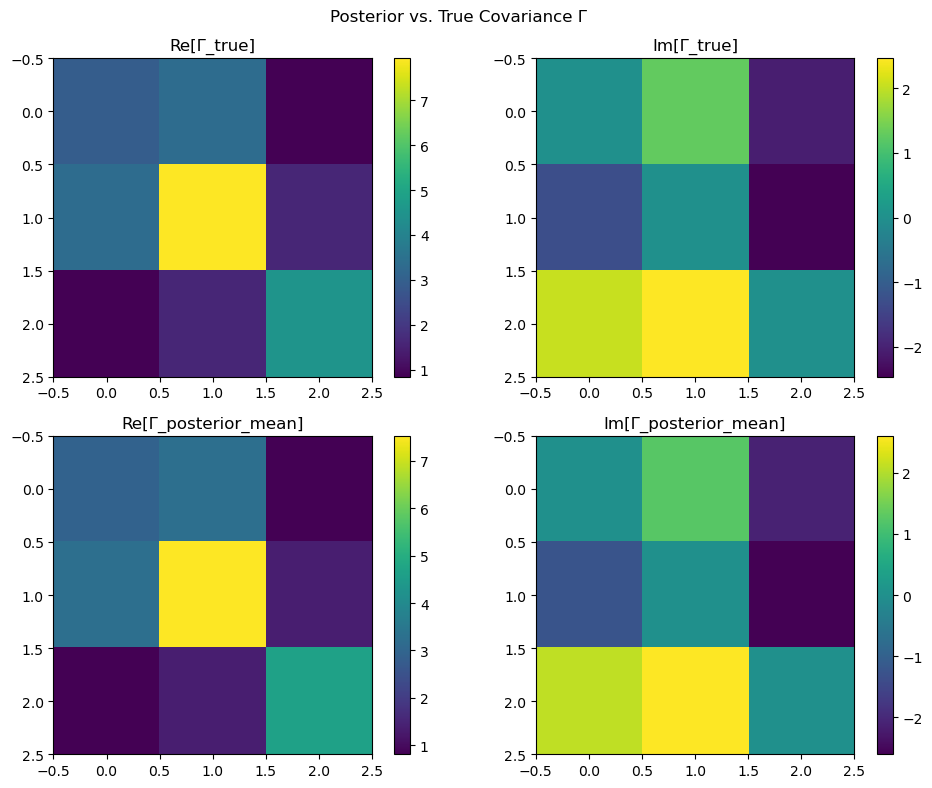

In [18]:
plot_complex_matrix_comparison(Gamma_true, np.array(Gamma_mean))


Sick - we now have what we want for the full-rank case. 

### Next 
- explore the results a bit
    - eigvals and eigvecs
    - posterior predictive check
- understand numpyro a bit better
- low-rank case


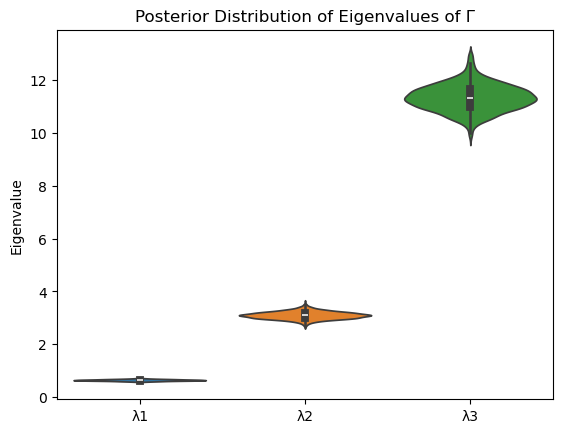

In [19]:
import seaborn as sns
import pandas as pd

eigvals = jnp.linalg.eigvalsh(Gamma_samples)  # shape: (n_samples, K)

df = pd.DataFrame(np.array(eigvals), columns=[f"λ{i+1}" for i in range(eigvals.shape[1])])
sns.violinplot(data=df)
plt.title("Posterior Distribution of Eigenvalues of Γ")
plt.ylabel("Eigenvalue")
plt.show()


/projectnb/stephenlab/jtauber/.conda/envs/pymc_env/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/projectnb/stephenlab/jtauber/.conda/envs/pymc_env/lib/python3.13/site-packages/numpy/lib/_histograms_impl.py:857: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
/projectnb/stephenlab/jtauber/.conda/envs/pymc_env/lib/python3.13/site-packages/matplotlib/axes/_axes.py:7127: ComplexWarning: Casting complex values to real discards the imaginary part
  bins = np.array(bins, float)  # causes problems if float16


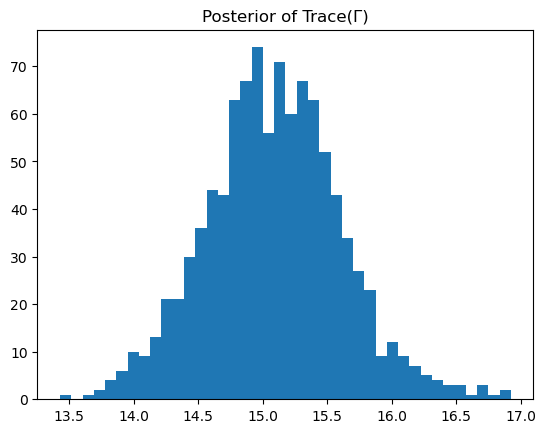

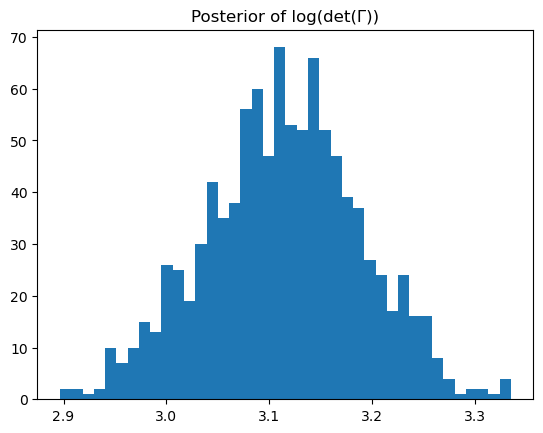

In [20]:
traces = jnp.trace(Gamma_samples, axis1=1, axis2=2)         # shape (n_samples,)
logdets = jnp.linalg.slogdet(Gamma_samples)[1]              # shape (n_samples,)

plt.hist(np.array(traces), bins=40)
plt.title("Posterior of Trace(Γ)")
plt.show()

plt.hist(np.array(logdets), bins=40)
plt.title("Posterior of log(det(Γ))")
plt.show()


NameError: name 'K' is not defined

In [22]:
n_samples = 1000
K = 3
Gamma_samples.shape == (n_samples, K, K)  # complex-valued matrices


True

In [24]:
import jax

def sample_fake_z(Gamma, key, n=500):
    K = Gamma.shape[0]
    eps = jax.random.normal(key, shape=(n, K)) + 1j * jax.random.normal(key, shape=(n, K))
    L = jax.scipy.linalg.cholesky(Gamma, lower=True)
    z_fake = (eps @ L.T.conj()) / jnp.sqrt(2)
    return z_fake

rng_keys = jax.random.split(jax.random.PRNGKey(0), 50)
fake_datasets = [sample_fake_z(Gamma_samples[i], rng_keys[i]) for i in range(50)]


In [25]:
def compute_marginal_variances(z):  # z: (n, K)
    return jnp.var(jnp.real(z), axis=0) + jnp.var(jnp.imag(z), axis=0)

real_var = compute_marginal_variances(z_obs)
fake_vars = jnp.array([compute_marginal_variances(z_fake) for z_fake in fake_datasets])


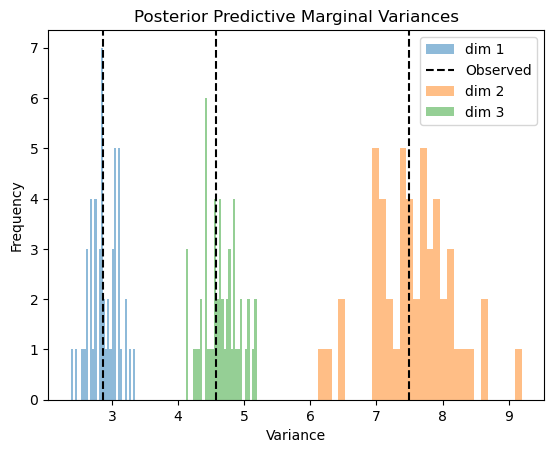

In [26]:
import matplotlib.pyplot as plt

for k in range(real_var.shape[0]):
    plt.hist(fake_vars[:, k], bins=30, alpha=0.5, label=f"dim {k+1}")
    plt.axvline(real_var[k], color='k', linestyle='--', label="Observed" if k == 0 else None)

plt.title("Posterior Predictive Marginal Variances")
plt.xlabel("Variance")
plt.ylabel("Frequency")
plt.legend()
plt.show()
